# 2次元の畳み込みニューラルネットワークスクラッチ


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import time

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


## データセットの用意


引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。



In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

## 【問題1】2次元畳み込み層の作成


In [4]:
## 初期化方法のクラス化

class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        """
        重みの初期化
        Parameters
        ----------

        Returns
        ----------
        W : (n_nodes1, n_nodes2,)
        W : (n_in_channels, n_out_channels, filter_size,)
        """
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        """
        バイアスの初期化
        Parameters
        ----------

        Returns
        ----------
        B : (n_out_channels,)
        B : (n_nodes2,)
        """
        B = self.sigma * np.random.randn(*shape)
        return B

In [5]:
## 最適化手法のクラス化

class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB

In [6]:
class Conv2d:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, st=1):
        self.optimizer = optimizer
        if type(filter_size) == int:
            self.filter_size_h = self.filter_size_w = filter_size
        else:
            self.filter_size_h = filter_size[0]
            self.filter_size_w = filter_size[1]
        if type(pa) == int:
            self.pa_h = self.pa_w = pa
        else:
            self.pa_h = pa[0]
            self.pa_w = pa[1]
        if type(st) == int:
            self.st_h = self.st_w = st
        else:
            self.st_h = st[0]
            self.st_w = st[1]
        self.W = initializer.W(n_out_channels, n_in_channels, self.filter_size_h, self.filter_size_w)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out_h = None
        self.n_out_w = None
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_in_channels, n_in_h, n_in_w)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, n_out_channels, n_out_h, n_out_w)
            出力
        """
        self.n_samples = X.shape[0]
        self.n_in_h = X.shape[-2]
        self.n_in_w = X.shape[-1]
        self.n_out_h = out_size(self.n_in_h, self.filter_size_h, self.pa_h, self.st_h)
        self.n_out_w = out_size(self.n_in_w, self.filter_size_w, self.pa_w, self.st_w)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in_h, self.n_in_w)
        
        self.X = np.pad(X, ((0,0),(0,0),(self.pa_h,self.pa_h),(self.pa_w,self.pa_w)), 'constant')
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out_h, self.n_out_w))        
        for t in range(self.n_samples):
            for k in range(self.n_out_channels):
                for i in range(self.n_out_h):
                    for j in range(self.n_out_w):
                        for m in range(self.n_in_channels):
                            for s in range(self.filter_size_h):
                                for u in range(self.filter_size_w):
                                    A[t, k, i, j] += self.X[t, m, i*self.st_h + s, j*self.st_w + u]*self.W[k, m, s, u]
                        A[t, k, i, j] += self.B[k]
        return A
    

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (n_samples, n_out_channels, n_out_h, n_out_w)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (n_samples, n_in_channels, n_in_h, n_in_w)
            前に流す勾配
        """
        
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        for t in range(self.n_samples):
            for k in range(self.n_out_channels):
                for i in range(self.n_out_h):
                    for j in range(self.n_out_w):
                        for m in range(self.n_in_channels):
                            for s in range(self.filter_size_h):
                                for u in range(self.filter_size_w):
                                    self.dW[k, m, s, u] += dA[t, k, i, j]*self.X[t, m, i*self.st_h+s, j*self.st_w+u]
                        self.dB[k] += dA[t, k, i, j]
        dX = np.zeros(self.X.shape)
        for t in range(self.n_samples):
            for m in range(self.n_in_channels):
                for i in range(self.n_in_h):
                    for j in range(self.n_in_w):
                        for k in range(self.n_out_channels):
                            for s in range(self.filter_size_h):
                                for u in range(self.filter_size_w):
                                    if 0 <= i-s <= self.n_out_h-1 and 0 <= j-u <= self.n_out_w-1:
                                        dX[t, m, i, j] += dA[t, k, i-s, j-u]*self.W[k, m, s, u]
        
        self.optimizer.update(self)
        return dX

In [7]:
def out_size(in_size, f, p=0, s=1): 
    return int((in_size+2*p-f) // s) + 1

### テスト

In [8]:
conv2d = Conv2d(filter_size=[1, 3], initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=1, n_out_channels=1, pa=[0, 0])

In [9]:
x = np.array([[[[1,5,0,2,8,1], [1,5,0,2,8,1]]], [[[1,5,0,2,8,1], [1,5,0,2,8,1]]]])
conv2d.W = np.array([[[[-1, 2, -1]]]], dtype=float)
conv2d.B = np.array([0], dtype=float)

In [10]:
print(x.shape)
print(conv2d.W.shape)

(2, 1, 2, 6)
(1, 1, 1, 3)


## 【問題2】2次元畳み込み後の出力サイズ

問題１に付随させた

## 【問題3】最大プーリング層の作成


In [11]:
class MaxPool2D:
    def __init__(self, st):
        self.st_h = st[0]
        self.st_w = st[1]
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_in_channels, n_in_h, n_in_w)
            入力
        """
        self.X = X
        self.n_samples, self.n_in_channels, self.n_in_h, self.n_in_w = X.shape
        A = np.zeros((self.n_samples, self.n_in_channels, self.n_in_h//self.st_h, self.n_in_w//self.st_w))
        self.Aij = np.zeros(((self.n_in_h*self.n_in_w)//(self.st_h*self.st_w), X.ndim), dtype=int)
        for t in range(self.n_samples):
            for m in range(self.n_in_channels):
                for i in range(self.n_in_h//self.st_h):
                    for j in range(self.n_in_w//self.st_w):
                        X1 = X[t, m, i*self.st_h:(i+1)*self.st_h, j*self.st_w:(j+1)*self.st_w]
                        A[t, m, i, j] = np.max(X1)
                        idx = np.argmax(X1)
                        self.Aij[i*(self.n_in_w//self.st_w) + j] = np.array([t, m, i*self.st_h + idx//self.st_h, j*self.st_w + idx%self.st_h], dtype=int)
        return A
    
    def backward(self, dA):
        a = np.zeros(self.X.shape)
        a[tuple(self.Aij.T)] = 1
        return a*dA

## 【問題5】平滑化


In [12]:
class Flatten:
    
    def forward(self, A):
        self.n_samples, self.n_out_channels, self.n_out_h, self.n_out_w = A.shape
        return A.reshape(self.n_samples, -1)
    
    def backward(self, dA):
        return dA.reshape(self.n_samples, self.n_out_channels, self.n_out_h, self.n_out_w)


In [13]:
class ActSigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
class ActTanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class ActSoftmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    
    def loss_func(self, Y, Z=None):
        """
        y_true : (n_samples, n_output)
        z : (n_samples, n_output)
        """
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))
    
class ActReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class ScratchConvNeuralNetrowkClassifier:
    
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, 
                 n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 verbose=True, Activater=ActTanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        # self.n_nodes1 = n_nodes1 # 1層目のノード数 # self.conv2d.n_out になる
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        
        self.Activater = Activater
        if Activater == ActSigmoid or Activater == ActTanh:
            self.Initializer = XavierInitializer
        elif Activater == ActReLU:
            self.Initializer = HeInitializer
        else:
            print("活性化関数が不適切")
        self.Optimizer = Optimizer
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
        #optimizer = self.Optimizer(self.lr)
        self.conv2d = Conv2d(filter_size=[7, 7], initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=[3, 3], st=[2, 2])
        self.conv2d.n_out_h = out_size(X.shape[-2], self.conv2d.filter_size_h, self.conv2d.pa_h, self.conv2d.st_h)
        self.conv2d.n_out_w = out_size(X.shape[-1], self.conv2d.filter_size_w, self.conv2d.pa_w, self.conv2d.st_w)
        self.flatten = Flatten()
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.conv2d.n_out_h*self.conv2d.n_out_w, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = ActSoftmax()
        
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        
        for i in range(self.num_epoch):
            time0 = time.time()
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.iter = len(get_mini_batch)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))
            print("epoch[", i+1, "] : ", round(time.time()-time0, 2), "(s)", sep="")
        
        if self.verbose:
            self.learning_curve()
            print()

    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def forward_propagation(self, X):
        A1 = self.conv2d.forward(X)
        A1 = self.flatten.forward(A1)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
    def back_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = self.flatten.backward(dA1)
        dZ0 = self.conv2d.backward(dA1) # dZ0は使用しない
    
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, self.num_epoch*self.iter + 1), self.loss, label="train_loss")
        plt.plot(np.arange(0, self.num_epoch + 1)*self.iter, self.loss_epoch, label="epoch_loss")
        if self.val_enable:
            plt.plot(np.arange(1, self.num_epoch + 1), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()
        return
        
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X@self.W + self.B
        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [14]:
def evaluate(y_true, y_pred):
    print("accuracy =", accuracy_score(y_true, y_pred))
    print("precision =", precision_score(y_true, y_pred, average='macro'))
    print("recall =", recall_score(y_true, y_pred, average='macro'))
    print("f1 =", f1_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))

### データ前処理

In [15]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [16]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [17]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [19]:
#処理に時間がかかるので、データを減らす
X_train_ = X_train_[:3000]
y_train_ = y_train_[:3000]
X_val = X_val[:500]
y_val = y_val[:500]

epoch[1] : 173.21(s)
epoch[2] : 172.14(s)
epoch[3] : 180.19(s)
epoch[4] : 175.77(s)
epoch[5] : 175.71(s)
epoch[6] : 167.83(s)
epoch[7] : 166.63(s)
epoch[8] : 164.36(s)
epoch[9] : 165.01(s)
epoch[10] : 398.26(s)
epoch[11] : 163.76(s)
epoch[12] : 165.85(s)
epoch[13] : 166.43(s)
epoch[14] : 306.03(s)
epoch[15] : 165.26(s)
epoch[16] : 1032.21(s)
epoch[17] : 166.07(s)
epoch[18] : 7967.12(s)
epoch[19] : 1287.44(s)
epoch[20] : 165.45(s)
epoch[21] : 165.01(s)
epoch[22] : 168.7(s)
epoch[23] : 2742.1(s)
epoch[24] : 169.04(s)
epoch[25] : 175.22(s)
epoch[26] : 170.76(s)
epoch[27] : 164.43(s)
epoch[28] : 166.77(s)
epoch[29] : 164.16(s)
epoch[30] : 165.39(s)


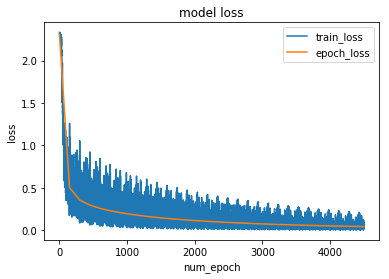

In [20]:
scratch_cnn1 = ScratchConvNeuralNetrowkClassifier(num_epoch=30, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Activater=ActReLU, Optimizer=AdaGrad)
scratch_cnn1.fit(X_train_, y_train_)

In [21]:
y_pred1 = scratch_cnn1.predict(X_test)

In [22]:
evaluate(y_test, y_pred1)

accuracy = 0.9367
precision = 0.9368172958196419
recall = 0.9361151443736639
f1 = 0.9362453709355023
[[ 959    0    3    2    2    3    5    1    3    2]
 [   0 1107    3    4    0    1    4    1   13    2]
 [  11    1  966   11    9    1   11    8   12    2]
 [   3    2   16  947    0   11    0    6   16    9]
 [   2    0    4    1  907    1   14    3    4   46]
 [   5    1    0   37    4  820    7    1   13    4]
 [  11    2    4    4    7   11  915    2    2    0]
 [   1    8   20   18    3    2    0  940    2   34]
 [   8    5    2   36    9   14    9    8  878    5]
 [   2    4    1   21   29    6    1    9    8  928]]


# 【問題9】出力サイズとパラメータ数の計算

In [ ]:
"""
1,
入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし
→ 出力サイズ : 142×142, 6チャンネル
→ パラメータサイズ : 54

2,
入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし
→ 出力サイズ : 58×58, 48チャンネル
→ パラメータサイズ : 432

3,
入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし
→ 出力サイズ : 9×9, 20チャンネル
→ パラメータサイズ : 180
"""